In [1]:
%cd ..
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

file_names = ['data/potholes_1.csv', 'data/potholes_2.csv']

potholes = pd.concat((pd.read_csv(i) for i in file_names))


potholes = potholes.iloc[:,
    [0, 1, 2, 5, 6, 9, 10, 11, 12, 13, 14, 16, 17, 18
    ]
]
potholes = potholes.dropna(subset = ["ZIP", "Community Area"])
potholes['Community Area'] = potholes['Community Area'].astype(int).astype('category')

# Rename variables
potholes.rename(columns = {"CREATION DATE": "Creation Date",
                          "STATUS" :"Status",
                          "COMPLETION DATE": "Completion Date",
                          "CURRENT ACTIVITY": "Current Activity",
                          "MOST RECENT ACTION": "Most Recent Action"}, inplace = True)

/home/jupyter/Python-Project-1


In [2]:
# Convert strings to times
potholes["Creation Date"] = pd.to_datetime(potholes["Creation Date"], format = "%m/%d/%Y")
potholes["Completion Date"] = pd.to_datetime(potholes["Completion Date"], format = "%m/%d/%Y")

# Create completion time variable
potholes["Completion Time"] = potholes["Completion Date"] - potholes["Creation Date"]
potholes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558055 entries, 1 to 310476
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   Creation Date       558055 non-null  datetime64[ns] 
 1   Status              558055 non-null  object         
 2   Completion Date     550786 non-null  datetime64[ns] 
 3   Current Activity    391921 non-null  object         
 4   Most Recent Action  390310 non-null  object         
 5   ZIP                 558055 non-null  float64        
 6   X COORDINATE        557921 non-null  float64        
 7   Y COORDINATE        557921 non-null  float64        
 8   Ward                558054 non-null  float64        
 9   Police District     558054 non-null  float64        
 10  Community Area      558055 non-null  category       
 11  LATITUDE            557271 non-null  float64        
 12  LONGITUDE           557271 non-null  float64        
 13  LOCATION      

In [27]:
census_data = pd.read_csv('data/chicago_census_data.csv')
census_data = census_data.iloc[:, [0,1,7,8]].dropna()
census_data['HARDSHIP INDEX'] = census_data['HARDSHIP INDEX'].astype(int)
census_data = census_data.rename(columns = {'Community Area Number': 'Community Area', "COMMUNITY AREA NAME": "Community Area Name", "HARDSHIP INDEX": "Hardship Index", "PER CAPITA INCOME ": "Per Capita Income"})
census_data = census_data.dropna(subset=["Community Area", "Hardship Index", "Per Capita Income"])
print(census_data)

    Community Area Community Area Name  Per Capita Income  Hardship Index
0              1.0         Rogers Park              23939              39
1              2.0          West Ridge              23040              46
2              3.0              Uptown              35787              20
3              4.0      Lincoln Square              37524              17
4              5.0        North Center              57123               6
..             ...                 ...                ...             ...
72            73.0   Washington Height              19713              48
73            74.0     Mount Greenwood              34381              16
74            75.0         Morgan Park              27149              30
75            76.0              O'Hare              25828              24
76            77.0           Edgewater              33385              19

[77 rows x 4 columns]


In [16]:
potholes_c = potholes.groupby(["Community Area"])['Creation Date'].count()
potholes_mean = potholes.groupby(["Community Area"]).agg({'Completion Time': 'mean'})
pd_holes = potholes_c.to_frame(name='Count').reset_index()
potholes_mean["Completion Time"] = potholes_mean["Completion Time"].apply(lambda x: x.days)

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 78 entries, 0 to 77
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Completion Time  78 non-null     int64
dtypes: int64(1)
memory usage: 3.3 KB


In [18]:
census_data.rename(columns = {}, inplace = True)
census_data['Community Area'] = census_data['Community Area'].astype(int)
merged_data = pd.merge(census_data, pd_holes, on = 'Community Area')
working_data = pd.merge(merged_data, potholes_mean, on = 'Community Area').sort_values(["Completion Time"], ascending = False)
working_data['Community Area'] = working_data['Community Area'].astype('category')
working_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 13 to 58
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Community Area     77 non-null     category
 1   Per Capita Income  77 non-null     int64   
 2   Hardship Index     77 non-null     int64   
 3   Count              77 non-null     int64   
 4   Completion Time    77 non-null     int64   
dtypes: category(1), int64(4)
memory usage: 5.7 KB


Text(0, 0.5, 'Average Completion Time')

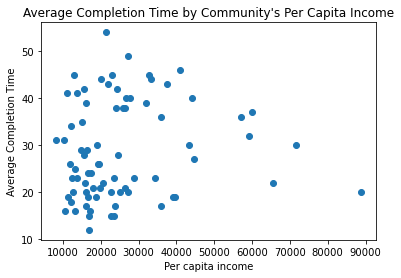

In [19]:
%matplotlib inline
plt.scatter(working_data["Per Capita Income"], working_data["Completion Time"])
plt.title("Average Completion Time by Community's Per Capita Income")
plt.xlabel("Per capita income")
plt.ylabel("Average Completion Time")

In [23]:
# What is the per capita income of commmunities with top 5 longest completion times?
# Bottom 5?
top_5 = working_data[working_data["Completion Time"] >= 45]
print(top_5)

'''
bottom_5 = working_data[working_data["Completion Time"] <= 16]
bottom_5

plt.bar(top_5["Community Area"], top_5["Per Capita Income"])
#Name each Community Area so x-axis is categorical?
'''

   Community Area  Per Capita Income  Hardship Index  Count  Completion Time
13             14              21323              53   8118               54
15             16              27249              34  12358               49
8               9              40959               8   5003               46
1               2              23040              46  15426               45
26             27              12961              83   4227               45
9              10              32875              21  14227               45


'\nbottom_5 = working_data[working_data["Completion Time"] <= 16]\nbottom_5\n\nplt.bar(top_5["Community Area"], top_5["Per Capita Income"])\n#Name each Community Area so x-axis is categorical?\n'